In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata
import os



In [2]:
import sys
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

In [4]:
counts_1 = pd.read_csv('data/star_counts.tab.gz', sep='\t', index_col=0)
rd_1 = pd.read_csv('data/rd_pc2.tab.gz', sep='\t', index_col=0)
meta_1 = pd.read_csv('data/SraRunTable.txt.gz', index_col=0)
star_meta_1 = pd.read_csv('data/star_meta.tab.gz', sep='\t', index_col=0)

discard = ['EGFP'] + [x for x in counts_1.index if x[:5]=='ERCC-']
good_genes = [x for x in counts_1.index if x not in discard]
counts_1 = counts_1.loc[good_genes, rd_1.index].T

In [5]:
counts_2 = pd.read_csv('data_chen/star_counts.tab.gz', sep='\t', index_col=0)
rd_2 = pd.read_csv('data_chen/rd_pc2.tab.gz', sep='\t', index_col=0)
meta_2 = pd.read_csv('data_chen/SraRunTable.txt.gz', sep='\t', index_col=5)
star_meta_2 = pd.read_csv('data_chen/star_meta.tab.gz', sep='\t', index_col=0)

counts_2 = counts_2[rd_2.index].T
meta_2 = meta_2.loc[rd_2.index]

In [58]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)

adata_1 = anndata.AnnData(counts_1)

sc.pp.filter_genes(adata_1, min_counts=3)
sc.pp.filter_cells(adata_1, min_counts=3)

adata_1.layers["counts"] = adata_1.X.copy()


gene_len = gene_len.reindex(adata_1.var.index).dropna()

# sc.pp.normalize_total(adata_1, target_sum=1e4)
# sc.pp.log1p(adata_1)
adata_1.raw = adata_1

adata_1.obs['Age'] = meta_1.loc[adata_1.obs.index].Age

# adata_1 = adata_1[:, gene_len.index]
# assert (adata_1.var.index == gene_len.index).sum() == adata_1.shape[1]
# adata_1.X = adata_1.X / gene_len[1].values * np.median(gene_len[1].values)
# # round to integer
# adata_1.X = np.rint(adata_1.X)

In [59]:

# gene_len.head()

adata_2 = anndata.AnnData(counts_2)

sc.pp.filter_genes(adata_2, min_counts=3)
sc.pp.filter_cells(adata_2, min_counts=3)

adata_2.layers["counts"] = adata_2.X.copy()
gene_len = gene_len.reindex(adata_2.var.index).dropna()


# sc.pp.normalize_total(adata_2, target_sum=1e4)
# sc.pp.log1p(adata_2)
adata_2.raw = adata_2

adata_2.obs['Age'] = meta_2.loc[adata_2.obs.index].cell_type_s

# adata_2 = adata_2[:, gene_len.index]
# assert (adata_2.var.index == gene_len.index).sum() == adata_2.shape[1]
# adata_2.X = adata_2.X / gene_len[1].values * np.median(gene_len[1].values)
# # round to integer
# adata_2.X = np.rint(adata_2.X)

,n_counts,Age,batch
SRR7408400-0,492781.0,embryonic day 13.5,0
SRR7408401-0,804769.0,embryonic day 13.5,0
SRR7408404-0,1562686.0,embryonic day 13.5,0
SRR7408413-0,707476.0,embryonic day 13.5,0
SRR7408414-0,1402388.0,embryonic day 13.5,0
...,...,...,...
SRR3211942-1,964950.0,Epi,1
SRR3211943-1,1870145.0,Epi,1
SRR3211944-1,1926388.0,Epi,1
SRR3211945-1,445278.0,Epi,1


In [113]:
adata = adata_1.concatenate(adata_2)
adata.layers["counts"] = adata.X.copy()

# new_batch = []
# for cell in adata.obs.Age:
#     if cell == 'embryonic day 13.5':
#         new_batch.append(0)
#     elif cell == 'embryonic day 15.5':
#         new_batch.append(1)
#     elif cell == 'embryonic day 18.5':
#         new_batch.append(2)
#     elif cell == 'postnatal day 1':
#         new_batch.append(3)
#     elif cell == 'postnatal day 7':
#         new_batch.append(4)
#     elif cell == 'postnatal day 90':
#         new_batch.append(5)
        
#     elif cell == 'ES2i':
#         new_batch.append(6)
        
#     elif cell == 'ES':
#         new_batch.append(7)
        
#     elif cell == 'Epi':
#         new_batch.append(8)
#     elif cell == 'Motor neuron':
#         new_batch.append(9)
        
# adata.obs.batch = new_batch


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=500,
    layer="counts",
    batch_key="batch",
    subset=True
)

/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [126]:
scvi.data.setup_anndata(adata, layer="counts", batch_key="batch")
# vae = scvi.model.LinearSCVI(adata, n_latent=5)
vae = scvi.model.SCANVI(adata, n_latent=5)
vae.train()


INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1685 cells, 500 vars, 10 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `i

TypeError: __init__() missing 1 required positional argument: 'unlabeled_category'

In [121]:
adata.obsm["X_scVI"] = vae.get_latent_representation()


sc.pp.neighbors(adata, use_rep="X_scVI")
# sc.tl.leiden(adata)
sc.tl.umap(adata)

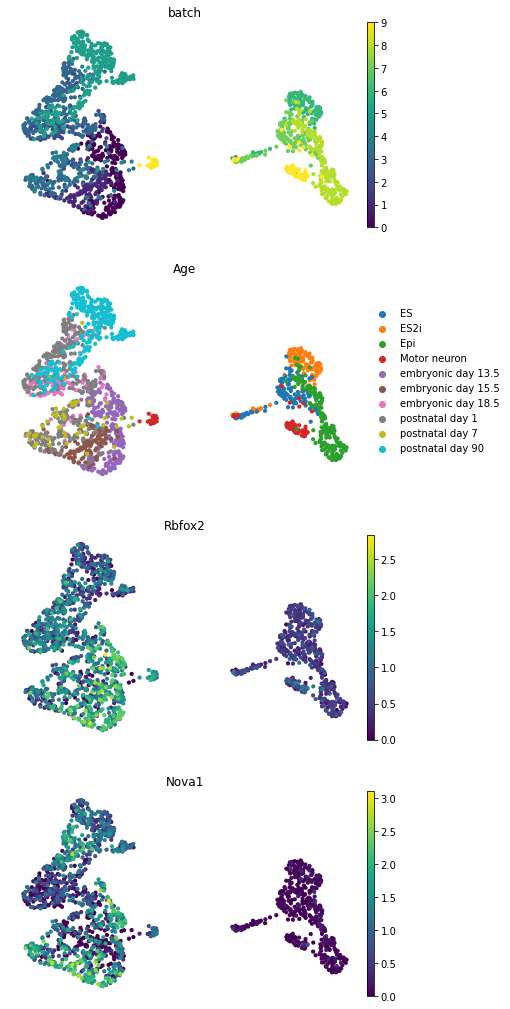

In [122]:
sc.pl.umap(
    adata,
    color=["batch", "Age", 'Rbfox2', 'Nova1'],
    frameon=False,
    ncols=1,
)

/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


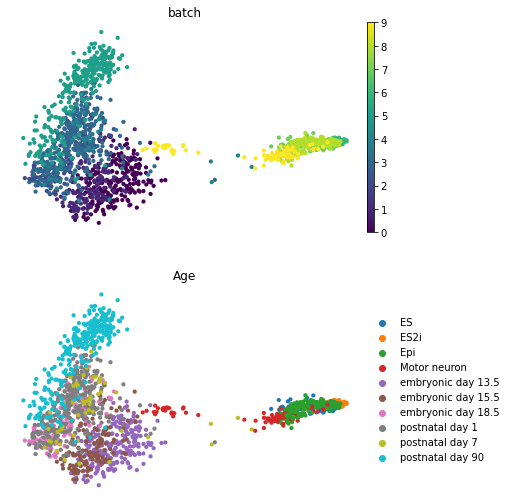

In [123]:
sc.tl.pca(adata)
sc.pl.pca(
    adata,
    color=["batch", "Age"],
    frameon=False,
    ncols=1,
)

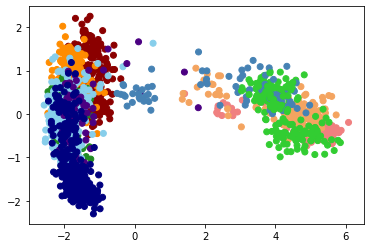

In [124]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in adata.obs.Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    elif cell == 'embryonic day 15.5':
        colores.append('darkorange')
    elif cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    elif cell == 'postnatal day 1':
        colores.append('skyblue')
    elif cell == 'postnatal day 7':
        colores.append('indigo')
    elif cell == 'postnatal day 90':
        colores.append('navy')
        
    elif cell == 'ES2i':
        colores.append('lightcoral')
        
    elif cell == 'ES':
        colores.append('sandybrown')
        
    elif cell == 'Epi':
        colores.append('limegreen')
    elif cell == 'Motor neuron':
        colores.append('steelblue')
        
pc = PCA(2).fit_transform(adata.obsm['X_scVI'])
plt.scatter(pc.T[0], -pc.T[1], c=colores)

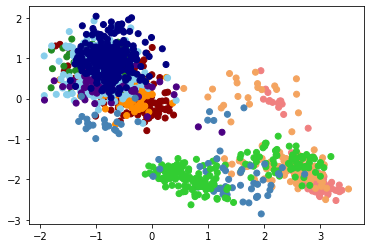

In [125]:
plt.scatter(adata.obsm['X_scVI'].T[0], adata.obsm['X_scVI'].T[1], c=colores)

In [44]:
adata.obs.Age.unique()

['embryonic day 13.5', 'embryonic day 15.5', 'embryonic day 18.5', 'postnatal day 1', 'postnatal day 7', 'postnatal day 90', 'ES2i', 'ES', 'Epi', 'Motor neuron']
Categories (10, object): ['embryonic day 13.5', 'embryonic day 15.5', 'embryonic day 18.5', 'postnatal day 1', ..., 'ES2i', 'ES', 'Epi', 'Motor neuron']

In [62]:
adata.obs

,n_counts,Age,batch,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
SRR7408400-0,492781.0,embryonic day 13.5,0,0,0,12.751012,0.198248
SRR7408401-0,804769.0,embryonic day 13.5,0,0,0,12.751012,0.198248
SRR7408404-0,1562686.0,embryonic day 13.5,0,0,0,12.751012,0.198248
SRR7408413-0,707476.0,embryonic day 13.5,0,0,0,12.751012,0.198248
SRR7408414-0,1402388.0,embryonic day 13.5,0,0,0,12.751012,0.198248
...,...,...,...,...,...,...,...
SRR3211942-1,964950.0,Epi,1,1,0,11.690040,0.810081
SRR3211943-1,1870145.0,Epi,1,1,0,11.690040,0.810081
SRR3211944-1,1926388.0,Epi,1,1,0,11.690040,0.810081
SRR3211945-1,445278.0,Epi,1,1,0,11.690040,0.810081
